# **1. Data Cleaning**

## *Table of Contents*

1. [**Data Cleaning**](./1_Data_Cleaning.ipynb)
   1. [*Library Imports*](#Library-Imports)
   2. [*File Importation*](#File-Importation)
   3. [*Pre-Cleaned Data Inspection*](#Pre-Cleaned-Data-Inspection)
   4. [*Data Preparation / Cleaning for Model Fitting*](#Data-Preparation--Cleaning-for-Model-Fitting)
   5. [*Post-Cleaning Data Inspection*](#Post-Cleaning-Data-Inspection)
   6. [*'BuildingArea' Imputation*](#BuildingArea-Imputation)
   7. [*Post-Analysis of 'BuildingArea' Imputation*](#Post-Analysis-of-'BuildingArea'-Imputation)
   8. [*Export Data*](#Export-Data)
2. [EDA and Feature Engineering](../02_Exploratory_Data_Analysis/2_Exploratory_Data_Analysis.ipynb)
3. [Regression Modeling](../03_Regression_Models/3_Regression_Modeling.ipynb)
4. [Time Series](../04_Time_Series_Analysis/4_Time_Series.ipynb)

## **Library Imports**

### Standard library imports

In [1]:
import sys # Provides a way of using operating system dependent functionality
import os  # For interacting with the operating system

### Third-party imports

In [2]:
import matplotlib.pyplot as plt  # For creating visualizations
import missingno as msno  # For visualizing missing data
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis
import seaborn as sns  # For high-level data visualization

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV, SelectKBest, mutual_info_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score, 
                                     StratifiedKFold, KFold)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

### Local application imports

In [3]:
# Define the absolute path of the parent directory of the script's grandparent directory
# This is useful for module importation from a different directory structure
parent_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, parent_dir)

# Local application imports
from utils import plot_utils, func_utils

## **File Importation**

In [4]:
# Determine the absolute path to the directory containing the current script
script_dir = os.path.dirname(os.getcwd())

# Construct the path to the data file
data_path = os.path.join(script_dir, '00_Raw_Data', '0_melb_data.csv')

# Load the dataset, parsing dates to ensure proper datetime format
melb_data = pd.read_csv(data_path, parse_dates=['Date'], dayfirst=True)

C:\Users\AAA\AppData\Local\Temp\ipykernel_46848\3112342448.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  melb_data = pd.read_csv(data_path, parse_dates=['Date'], dayfirst=True)


### Date Extraction

In [5]:
# Data manipulation: extracting year and month from the date for further analysis
melb_data['Year'] = melb_data['Date'].dt.year
melb_data['Month'] = melb_data['Date'].dt.month
melb_data['Date'] = melb_data['Date'].dt.date  # Simplify 'Date' to date format

### Drop Duplicates

In [6]:
# Remove duplicate entries to maintain data integrity
melb_data.drop_duplicates(inplace=True)

## **Pre-Cleaned Data Inspection**

              Rooms         Price      Distance      Postcode      Bedroom2  \
count  13579.000000  1.357900e+04  13579.000000  13579.000000  13579.000000   
mean       2.938066  1.075709e+06     10.137897   3105.296045      2.914721   
std        0.955749  6.393278e+05      5.868924     90.677724      0.965956   
min        1.000000  8.500000e+04      0.000000   3000.000000      0.000000   
25%        2.000000  6.500000e+05      6.100000   3044.000000      2.000000   
50%        3.000000  9.030000e+05      9.200000   3084.000000      3.000000   
75%        3.000000  1.330000e+06     13.000000   3148.000000      3.000000   
max       10.000000  9.000000e+06     48.100000   3977.000000     20.000000   

           Bathroom           Car      Landsize  BuildingArea    YearBuilt  \
count  13579.000000  13517.000000  13579.000000   7126.000000  8205.000000   
mean       1.534281      1.610121    518.087562    143.593649  1964.473248   
std        0.691722      0.962655   1272.523717     83

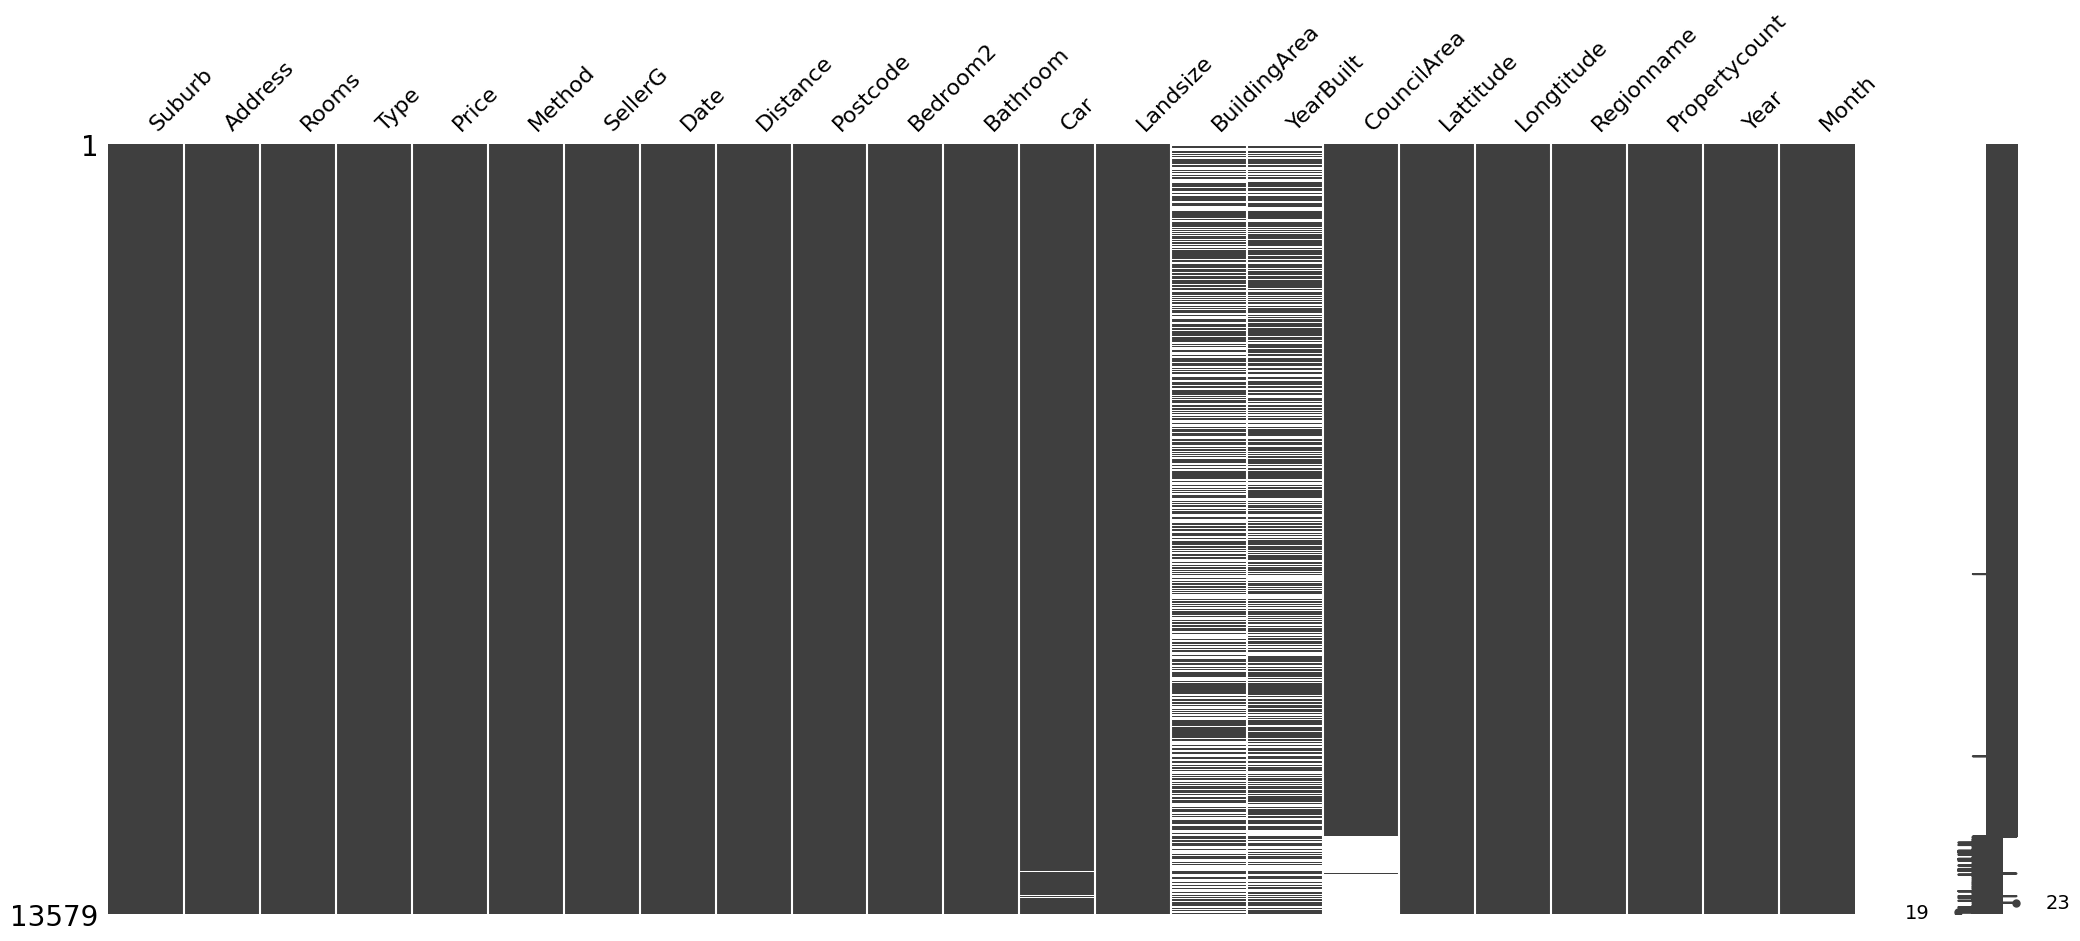

In [7]:
# Display summary statistics for the dataset
print(melb_data.describe())

# Identify missing values across columns
print('\n Missing values across columns:')
print(melb_data.isna().sum())

# Identify number of entries in dataset
print(f'\n Number of entries in dataset: {melb_data.shape[0]}')

# Visualize missing data to guide cleaning and imputation strategies
msno.matrix(melb_data)
plt.show()

## **Data Preparation / Cleaning for Model Fitting**

### Indicator Variable Creation

In [8]:
# Create binary indicators for specific conditions to enhance model interpretation
melb_data['Bathroom_was_0'] = np.where(melb_data['Bathroom'] == 0, True, False)
melb_data['Car_was_missing'] = melb_data['Car'].isna()
melb_data['BuildingArea_was_missing'] = melb_data['BuildingArea'].isna()

###  Resolving Missing Values and Errors

In [9]:
# Replace 0 bathroom counts with the median number of bathrooms.
melb_data['Bathroom'] = np.where(melb_data['Bathroom'] == 0, melb_data['Bathroom'].median(), melb_data['Bathroom'])

# Fill missing values in 'Car' column with the median number of cars.
melb_data.fillna(value={'Car': melb_data['Car'].median()}, inplace=True)

In [10]:
# Define a function to determine the effective number of bedrooms
# based on 'Rooms' and 'Bedroom2' columns
def effective_bedrooms(row):
    """
    Calculate the effective number of bedrooms for a property.
    
    This function takes into account discrepancies between 'Rooms' and 
    'Bedroom2' columns. It applies logic to decide the most representative 
    value for the number of bedrooms.

    Parameters:
    row (pd.Series): A row of the DataFrame.

    Returns:
    int: The calculated effective number of bedrooms.
    """
    if row['Rooms'] > row['Bedroom2'] and row['Bedroom2'] != 0:
        return row['Bedroom2']
    elif row['Rooms'] < row['Bedroom2'] and row['Rooms'] != 0:
        return row['Rooms']
    elif row['Rooms'] == row['Bedroom2']:
        return row['Rooms']
    else:
        return row['Rooms'] + row['Bedroom2']

# Apply the effective_bedrooms function to the dataset
melb_data['Bedroom'] = melb_data.apply(effective_bedrooms, axis=1)

In [11]:
def fill_councilarea(row):
    """
    Fill missing 'CouncilArea' based on properties in the same suburb.

    This function matches properties by 'Suburb', 'Postcode', 'Regionname', 
    and 'Propertycount' to fill missing 'CouncilArea' values. If a matching 
    property with a non-null 'CouncilArea' is found, its 'CouncilArea' value 
    is used.

    Parameters:
    row (pd.Series): A row from the DataFrame.

    Returns:
    str: The filled or original 'CouncilArea' value for the row.
    """
    if pd.isnull(row['CouncilArea']):
        match = melb_data[(row['Suburb'] == melb_data['Suburb']) & 
                          (row['Postcode'] == melb_data['Postcode']) & 
                          (row['Regionname'] == melb_data['Regionname']) & 
                          (row['Propertycount'] == melb_data['Propertycount']) & 
                          pd.notnull(melb_data['CouncilArea'])]
        if not match.empty:
            return match.iloc[0]['CouncilArea']
    return row['CouncilArea']

melb_data['CouncilArea'] = melb_data.apply(fill_councilarea, axis=1)

## **Post-Cleaning Data Inspection**

              Rooms         Price      Distance      Postcode      Bedroom2  \
count  13579.000000  1.357900e+04  13579.000000  13579.000000  13579.000000   
mean       2.938066  1.075709e+06     10.137897   3105.296045      2.914721   
std        0.955749  6.393278e+05      5.868924     90.677724      0.965956   
min        1.000000  8.500000e+04      0.000000   3000.000000      0.000000   
25%        2.000000  6.500000e+05      6.100000   3044.000000      2.000000   
50%        3.000000  9.030000e+05      9.200000   3084.000000      3.000000   
75%        3.000000  1.330000e+06     13.000000   3148.000000      3.000000   
max       10.000000  9.000000e+06     48.100000   3977.000000     20.000000   

           Bathroom           Car      Landsize  BuildingArea    YearBuilt  \
count  13579.000000  13579.000000  13579.000000   7126.000000  8205.000000   
mean       1.536785      1.611901    518.087562    143.593649  1964.473248   
std        0.687963      0.960814   1272.523717     83

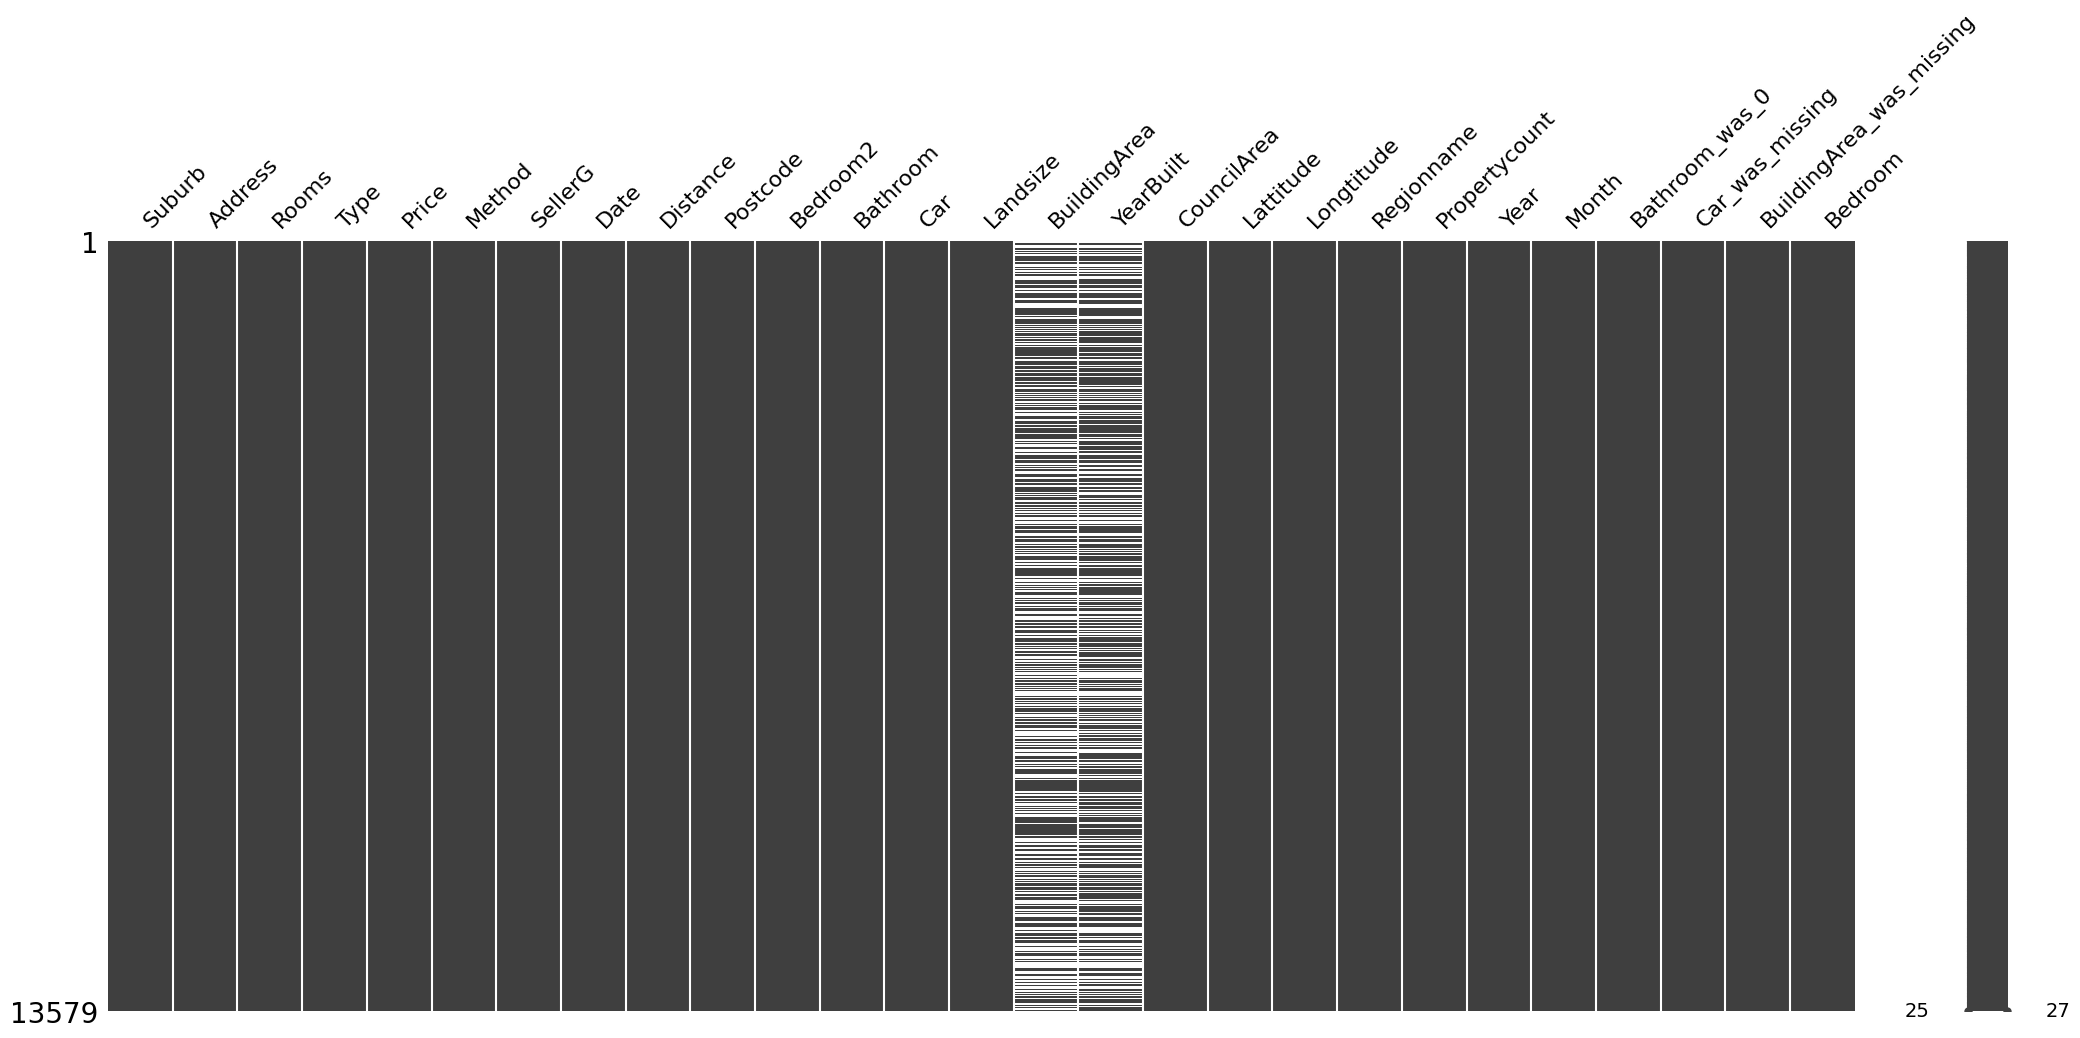

In [12]:
# Summarize the cleaned dataset to verify changes
print(melb_data.describe())

# Check for remaining missing values post-cleaning
print('\n Post-cleaning missing values across columns:')
print(melb_data.isna().sum())

# Visualize the cleaned data to ensure readiness for analysis
msno.matrix(melb_data)
plt.show()

### Handling Outliers

Identify and mitigate outliers in key quantitative columns such as 'Price', 'Bed', 'Bathroom', 'Car', 'Distance', 'Landsize', and 'BuildingArea'.


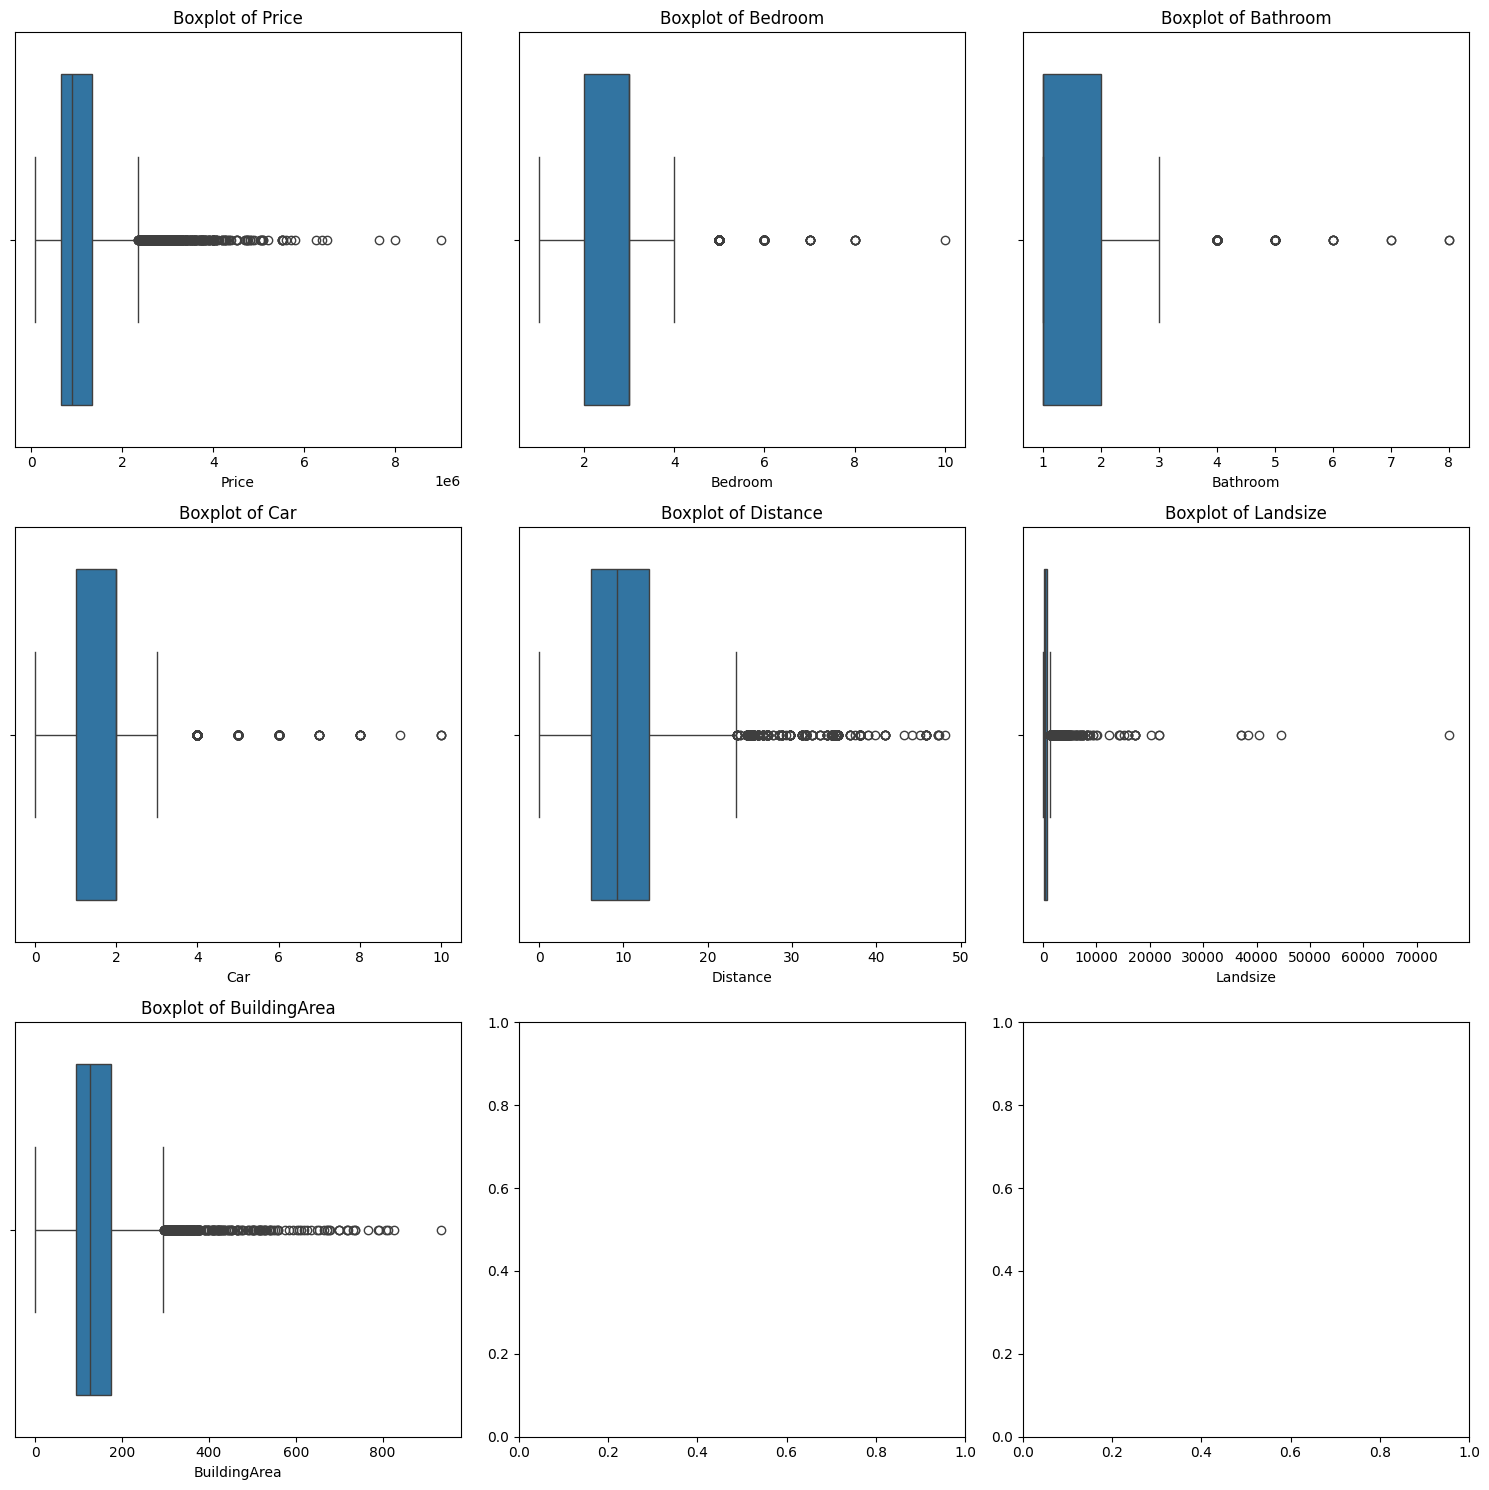

In [13]:
# Define quantitative columns
quant_columns = ['Price', 'Bedroom', 'Bathroom', 'Car', 'Distance', 'Landsize', 'BuildingArea']

# Plot boxplots to visualize outliers
plot_utils.plot_box(data=melb_data, column_list=quant_columns, rows=3, cols=3)

**Note**: Outliers were verified and do match the entries listed in the DataFrame.

#### Fixing Units with Zero Landsize

Units should not have a land size, so we will input zero for these entries as no one looks at the land size of a building for an apartment.

In [14]:
# Set 'Landsize' to 0 for units
melb_data.loc[melb_data['Type'] == 'u', 'Landsize'] = 0

# Create an indicator for imputed land sizes
melb_data['Landsize_Indicator'] = np.where(melb_data['Landsize'] == 0, 1, 0)

#### Handling Entries with Zero Building Area

A building area equal to zero does not make sense. We will impute these entries with our data.

In [15]:
# Impute 0 values in 'BuildingArea' with NaN
melb_data.loc[melb_data['BuildingArea'] == 0, 'BuildingArea'] = np.nan

### DataFrame Refinement

In [16]:
# Simplify the dataset by dropping columns not needed for further analysis
melb_data.drop(columns=['Rooms', 'Bedroom2', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount'], inplace=True)

# Reorder columns for readability and analysis purposes
melb_data = melb_data[[
    'Address', 'Postcode', 'Suburb', 'Regionname', 'CouncilArea', 'Type', 
    'Price', 'SellerG', 'Method', 'Date', 'Year', 'Month', 'Bedroom', 
    'Bathroom', 'Bathroom_was_0', 'Car', 'Car_was_missing', 'Distance',
    'Landsize', 'Landsize_Indicator', 'BuildingArea', 'BuildingArea_was_missing'
]]

## **'BuildingArea' Imputation**

### Preliminary Analysis

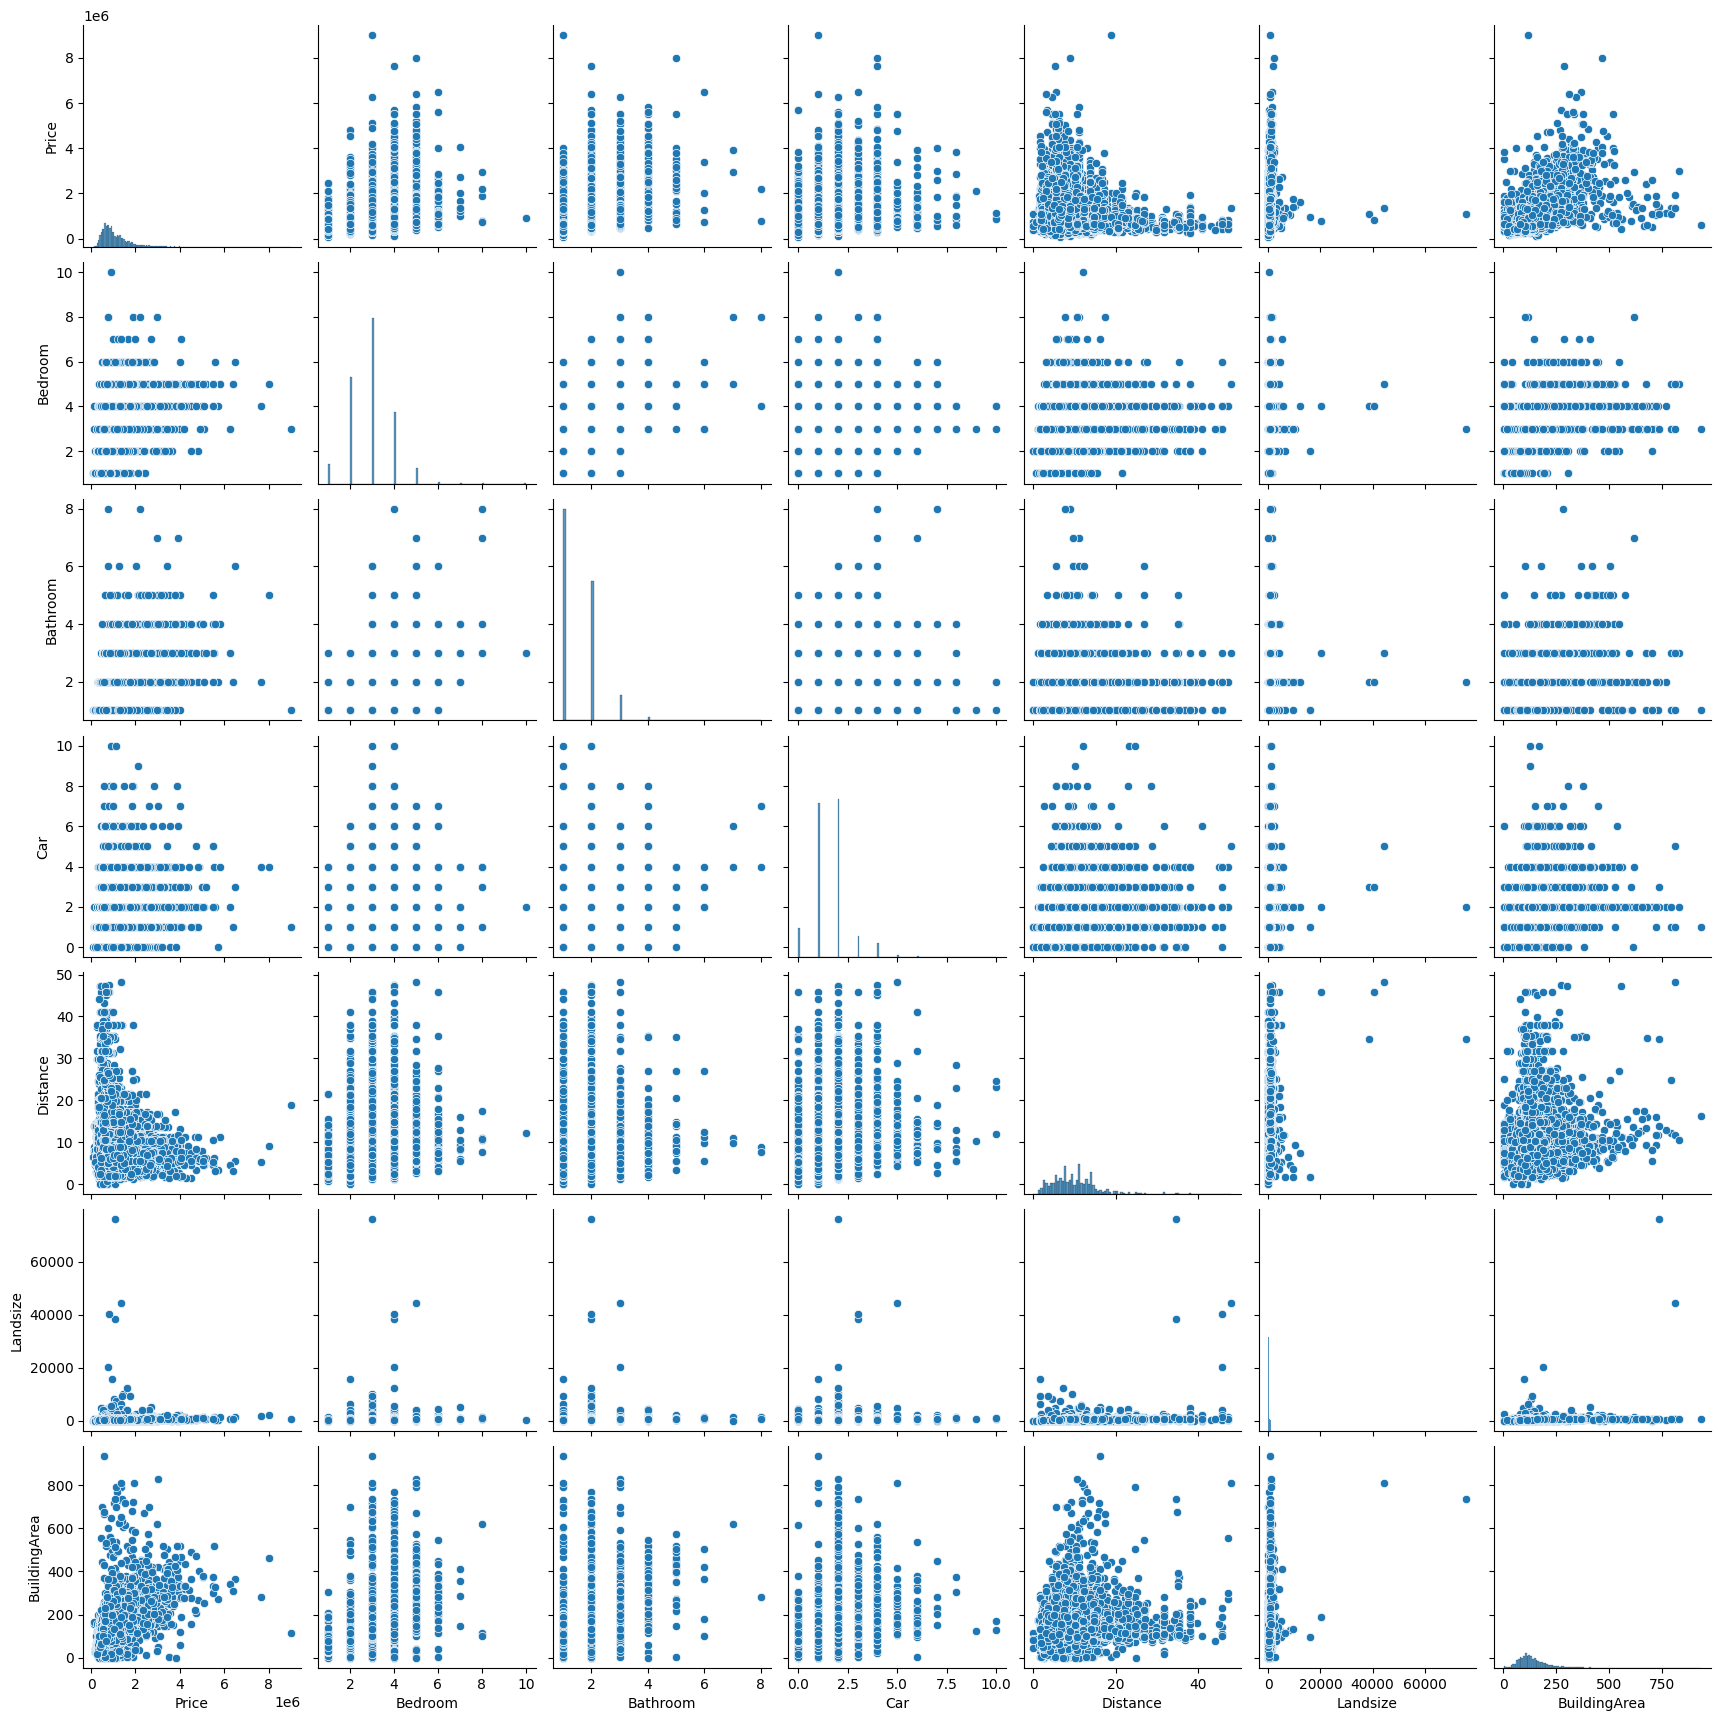

In [17]:
# Explore the relationships between quantitative variables and visualize correlations.
sns.pairplot(data=melb_data[quant_columns])
plt.show()

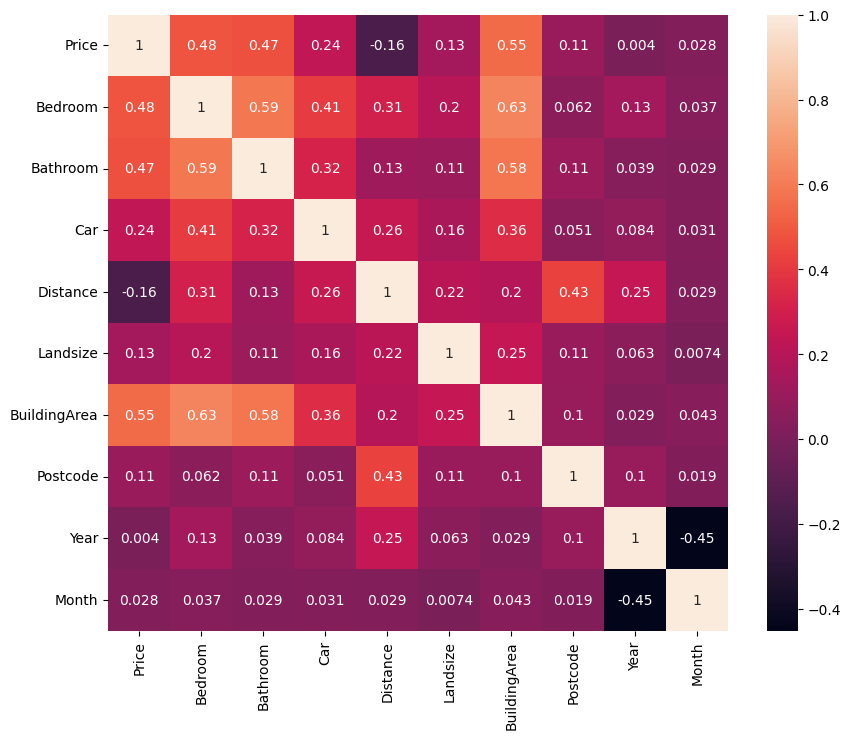

In [18]:
# Extend the list of quantitative columns with additional relevant features
quant_columns_ex = quant_columns + ['Postcode', 'Year', 'Month']

# Calculate the correlation matrix for the specified quantitative columns
corr_test = melb_data[quant_columns_ex].corr()

# Set the size of the figure
plt.figure(figsize=(10, 8))

# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_test, annot=True)
plt.show()

### Feature Selection

#### Preparation for Feature Selection

#### Mutual Information (MI)

Bedroom                       0.552482
Landsize                      0.314162
Bathroom                      0.303699
u_Type                        0.237443
Landsize_Indicator            0.210421
Car                           0.136442
Distance                      0.118491
Boroondara_Coun               0.029554
Melbourne_Coun                0.027461
2017_Year                     0.022774
Nguyen_Sell                   0.022548
3105_Post                     0.021676
3187_Post                     0.021123
Oakleigh South_Subu           0.021018
Paul_Sell                     0.020391
3146_Post                     0.019804
Toorak_Subu                   0.019697
Yarra_Coun                    0.019531
Dingley Village_Subu          0.019120
Yarra Glen_Subu               0.018761
Braybrook_Subu                0.018606
Marshall_Sell                 0.018548
3141_Post                     0.018390
3049_Post                     0.018049
3019_Post                     0.017990
Nillumbik_Coun                0.017854
Richmond_Subu                 0.017839
Johnston_Sell                 0.017555
3040_Post                     0.017001
Prahran_Subu                  0.016495
Bekdon_Sell                   0.016325
Epping_Subu                   0.016148
3051_Post                     0.015957
Walsh_Sell                    0.015920
Lalor_Subu                    0.015676
Cheltenham_Subu               0.015501
iProperty_Sell                0.015162
Nardella_Sell                 0.014943
Footscray_Subu                0.014940
TRUE_Sell                     0.014685
Kealba_Subu                   0.014679
Northern Metropolitan_Regi    0.014540
3103_Post                     0.014418
White_Sell                    0.014341
Wantirna_Subu                 0.014111
Beller_Sell                   0.014106
3802_Post                     0.014092
Brunswick West_Subu           0.014057
Brookfield_Subu               0.013974
3184_Post                     0.013950
3106_Post                     0.013908
Leeburn_Sell                  0.013690
Parkinson_Sell                0.013638
3775_Post                     0.013627
Doncaster East_Subu           0.013600
Altona Meadows_Subu           0.013470
iTRAK_Sell                    0.013444
Hillside_Subu                 0.013418
3183_Post                     0.013369
3099_Post                     0.013225
Southern Metropolitan_Regi    0.013173
Derrimut_Subu                 0.013153
3124_Post                     0.013063
3340_Post                     0.012998
Upwey_Subu                    0.012905
Gisborne_Subu                 0.012817
Frank_Sell                    0.012676
t_Type                        0.012499
3757_Post                     0.012479
Darebin_Coun                  0.012479
Lindellas_Sell                0.012374
Seddon_Subu                   0.012305
3186_Post                     0.012262
3194_Post                     0.012230
Pakenham_Subu                 0.012133
Clayton South_Subu            0.012106
3149_Post                     0.012050
3126_Post                     0.012028
Carlton North_Subu            0.011968
The Basin_Subu                0.011775
Ascend_Sell                   0.011745
Mill Park_Subu                0.011683
Chisholm_Sell                 0.011670
Fitzroy_Subu                  0.011600
Chadstone_Subu                0.011444
buyMyplace_Sell               0.011425
Watsonia_Subu                 0.011416
Nicholls_Sell                 0.011359
3033_Post                     0.011343
3205_Post                     0.011290
Metro_Sell                    0.011288
Thornbury_Subu                0.011194
Ashburton_Subu                0.011147
Allens_Sell                   0.011142
3795_Post                     0.011126
Cranbourne_Subu               0.011117
3174_Post                     0.011089
Essendon_Subu                 0.011039
3132_Post                     0.011031
3431_Post                     0.010993


##### APPLYING TOP N FEATURES TO DF

#### Recursive Feature Elimination (RFE)

**Initialize Your Estimator**:
Choose the model you want to use for feature selection and eventual prediction. Here, I'll use `RandomForestRegressor` as an example.


Now, apply `RFECV` to your data. You can specify the cross-validation strategy (e.g., K-fold) and the scoring metric you want to use.

*note*: we switched from `cv_strategy = StratifiedKFold(n_splits=5)` to `cv_strategy = KFold(n_splits=3, shuffle=True, random_state=42)` because `StratifiedKFold` is designed for classification tasks where the target variable is categorical (either binary or multiclass). For regression tasks, you should use `KFold` or another cross-validation generator that does not require the target to be categorical. 

**Review the Results**:
After fitting `RFECV` to your data, you can examine which features were selected and the optimal number of features.

Optimal number of features:  688


**Plot the CV Score vs. Number of Features**:
This helps visualize the performance of the model as you vary the number of features.

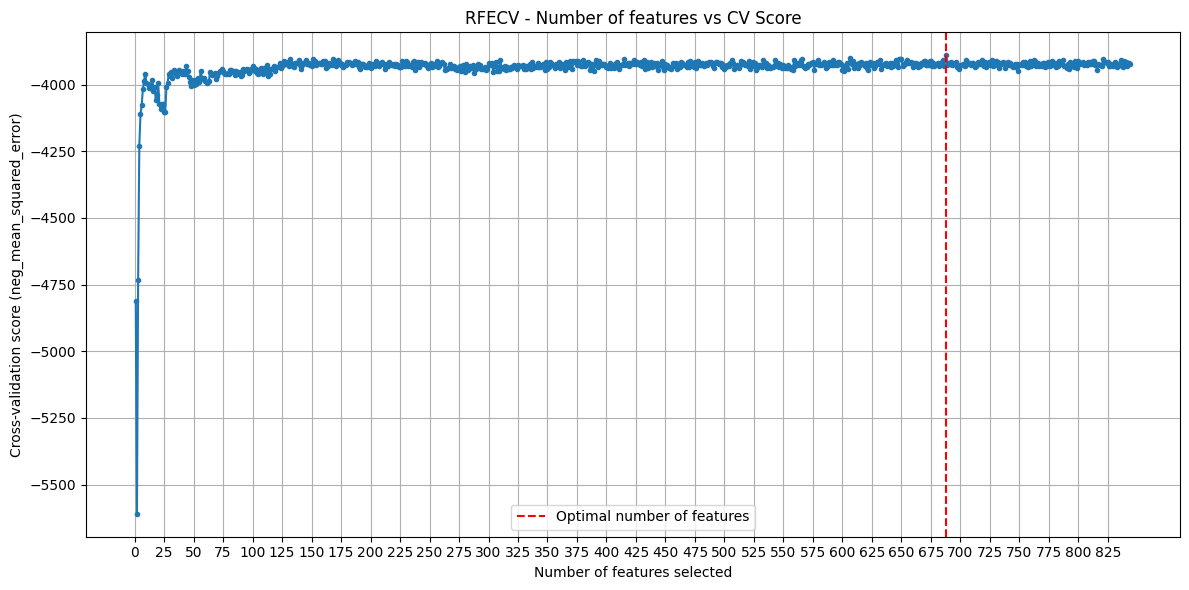

LOOK AT THE GRAPH AND THEN FITTING THE OPTIMAL FEATURES ON THE ACTUAL MODEL AND THEN LOOKING AT THE FEATURE IMPORTANT OF THE MODEL WILL TELL US WHICH TOP N FEATURE (IN OUR CASE LOOKING AT THE GRAPH IS 60) ARE THE MOST IMPORTANT FEATURE TO USE TO PREDICT OUR TARGET

### Preprocessing for Model Training

NOTE: WE FIRST OBTAIN THE `predictive_features` FROM FEATURE SELECTION RFE THEN WE FIT THE `predictive_features` ON THE PREDICTIVE RANDOM FOREST MODEL TO SEE OUT OF ALL THE 'OPTIMAL' FEATURES THAT RFECV PICKED WHICH HAVE THE MOST FEATURE RELEVENCE IN COMBANATION OF THE Plot THAT SHOW the CV Score vs. Number of Features WHICH SHOW USE THE MINUMUM # OF FEATURES WE COULD USE FOR THE BEST 'neg_mean_squared_error' SCORE. SO IN TAKING THE MINMUM # OF FEATURE FROM THE PLOT WE TAKE THE TOP N FEATURE THAT IS RELAVENT TO THE MODEL AND THEN WILL REINPUT IT IN THE predictive_features WHICH WILL GIVE US THE OPTIMAL NUMBER OF FEATURES TO USE TO FIT ON TO OUR MODEL TO PREDICT FOR MISSING VALUES OF `BuildingArea`

##### IF PIPLINE IS BEING USED

### GridSearchCV for Random Forest

##### IF PIPLINE IS BEING USED

### Random Forest Model Fitting

In [20]:
# Initialize the RandomForestRegressor with specified hyperparameters.
random_f_model = RandomForestRegressor(
    n_estimators=400, max_depth=10, min_samples_split=6,
    random_state=42, n_jobs=-1
)

# Fit the model to the training data.
random_f_model.fit(X_train, y_train)

# Predict on training and test data.
y_train_pred = random_f_model.predict(X_train)
y_test_pred = random_f_model.predict(X_test)

##### IF PIPLINE IS BEING USED

### Model Diagnostics

#### Cross Validation

In [21]:
# Perform 5-fold cross-validation to evaluate the model.
cv_scores = cross_val_score(random_f_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_scores = -cv_scores  # Convert scores to positive

# Print cross-validation scores, mean, and standard deviation.
print(f"CV MSE scores: {cv_scores}")
print(f"CV MSE mean: {cv_scores.mean()}")
print(f"CV MSE standard deviation: {cv_scores.std()}")

CV MSE scores: [4399.07294205 2685.04857731 3098.91194705 3855.0077313  4677.18097433]
CV MSE mean: 3743.044434407796
CV MSE standard deviation: 754.9545884100011


#### RMSE Calculation

In [22]:
# Calculate RMSE for both training and test datasets.
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Training RMSE: 46.01431736930155
Test RMSE: 58.98837735432151


#### MSE & MAE Calculation

In [23]:
# Calculate MSE and MAE for both training and test datasets.
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"\nTraining MAE: {train_mae}")
print(f"Test MAE: {test_mae}")

Training MSE: 2117.3174029628067
Test MSE: 3479.6286628958305

Training MAE: 27.405406970467304
Test MAE: 31.06003467045547


#### Feature Importance Analysis

In [24]:
# Assuming `X_train` includes both numerical and processed categorical variables.
feature_names = X_train.columns

# Extract feature importances from the model.
feature_importances = random_f_model.feature_importances_

# Create a Series for the feature importances for easy manipulation and sorting.
importances_series = pd.Series(
    feature_importances, index=feature_names
).sort_values(ascending=False)

print(importances_series)

'''
# Retrieve the top N feature names and their corresponding importance values.
top_features_count = 75
ind = importances_series.nlargest(top_features_count).index.tolist()
vals = importances_series.nlargest(top_features_count).values.tolist()
'''

Bedroom                0.513467
Bathroom               0.119904
Landsize               0.104906
Distance               0.026804
Car                    0.014043
                         ...   
3025_Post              0.001528
Altona North_Subu      0.001501
Forest Hill_Subu       0.001447
Glen Iris_Subu         0.001401
Ferntree Gully_Subu    0.001354
Length: 75, dtype: float64


'\n# Retrieve the top N feature names and their corresponding importance values.\ntop_features_count = 75\nind = importances_series.nlargest(top_features_count).index.tolist()\nvals = importances_series.nlargest(top_features_count).values.tolist()\n'

##### IF PIPLINE IS BEING USED

### Imputing Missing 'BuildingArea' using Predictive Model

In [25]:
# Predict 'BuildingArea' for rows where it is missing and impute these values.
X_missing = melb_predict_data[melb_predict_data[target].isnull()][predictive_features]
predicted_values = random_f_model.predict(X_missing)
rounded_pv = np.round_(predicted_values, decimals=0)

# Impute the predicted 'BuildingArea' back into the original dataset.
melb_predict_data.loc[melb_predict_data[target].isnull(), target] = rounded_pv

# Extract original dataset columns after imputation to remove dummy variables used for prediction.
# This step restores the dataframe to its initial structure, focusing on key attributes relevant
# for further analysis or reference, following the imputation of 'BuildingArea' using a RandomForest model.
melb_data = melb_predict_data[['Address', 'Postcode', 'Suburb', 'Regionname', 'CouncilArea', 'Type', 
    'Price', 'SellerG', 'Method', 'Date', 'Year', 'Month', 'Bedroom', 
    'Bathroom', 'Bathroom_was_0', 'Car', 'Car_was_missing', 'Distance',
    'Landsize', 'Landsize_Indicator', 'BuildingArea', 'BuildingArea_was_missing']].copy()

## **Post-Analysis of 'BuildingArea' Imputation**

           Postcode         Price          Year         Month       Bedroom  \
count  13579.000000  1.357900e+04  13579.000000  13579.000000  13579.000000   
mean    3105.296045  1.075709e+06   2016.533471      7.052508      2.899919   
std       90.677724  6.393278e+05      0.498897      2.535992      0.942561   
min     3000.000000  8.500000e+04   2016.000000      1.000000      1.000000   
25%     3044.000000  6.500000e+05   2016.000000      5.000000      2.000000   
50%     3084.000000  9.030000e+05   2017.000000      7.000000      3.000000   
75%     3148.000000  1.330000e+06   2017.000000      9.000000      3.000000   
max     3977.000000  9.000000e+06   2017.000000     12.000000     10.000000   

           Bathroom           Car      Distance      Landsize  \
count  13579.000000  13579.000000  13579.000000  13579.000000   
mean       1.536785      1.611901     10.137897    412.037263   
std        0.687963      0.960814      5.868924   1001.844626   
min        1.000000      0.0

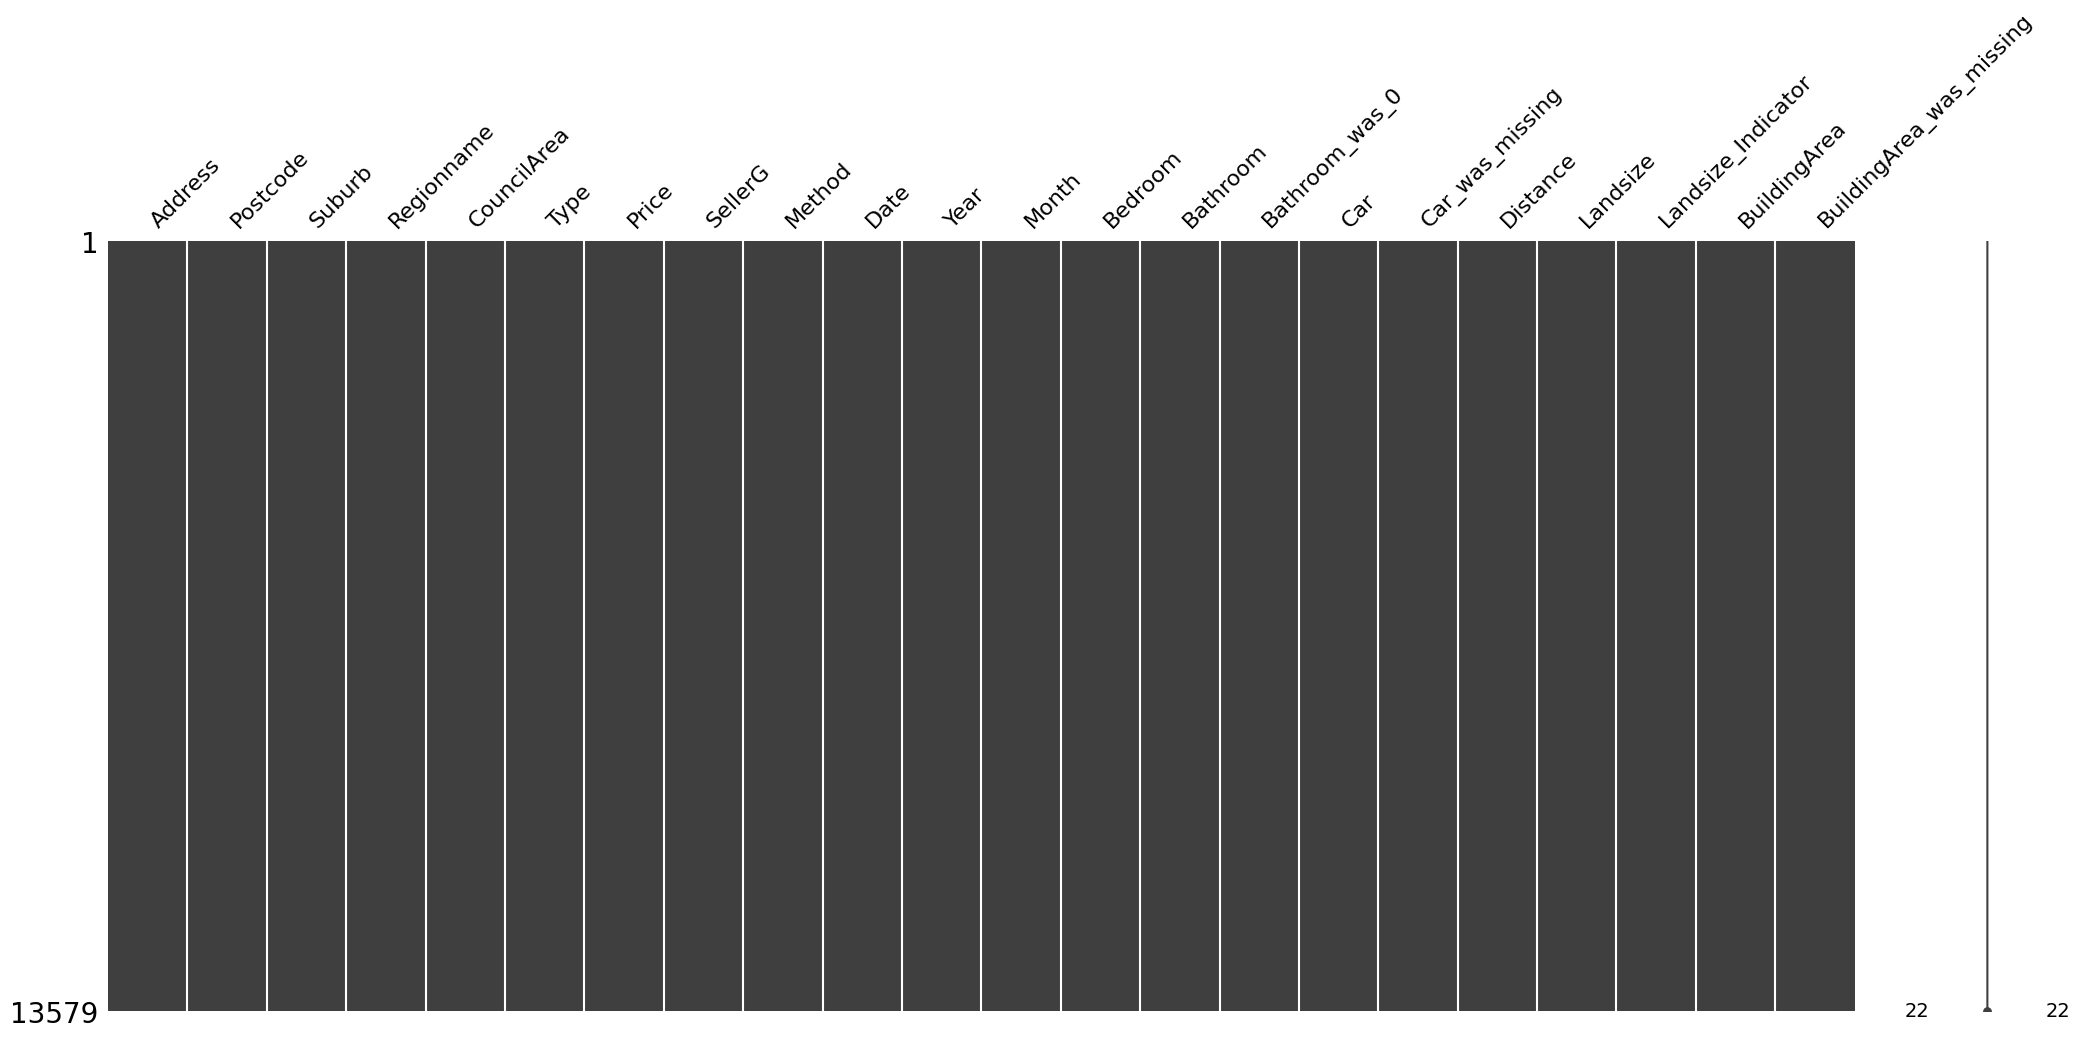

In [26]:
# Summarize the cleaned dataset to verify changes
print(melb_data.describe())

# Check for remaining missing values post-cleaning
print('\n Post-cleaning missing values across columns:')
print(melb_data.isna().sum())

# Visualize the cleaned data to ensure readiness for analysis
msno.matrix(melb_data)
plt.show()

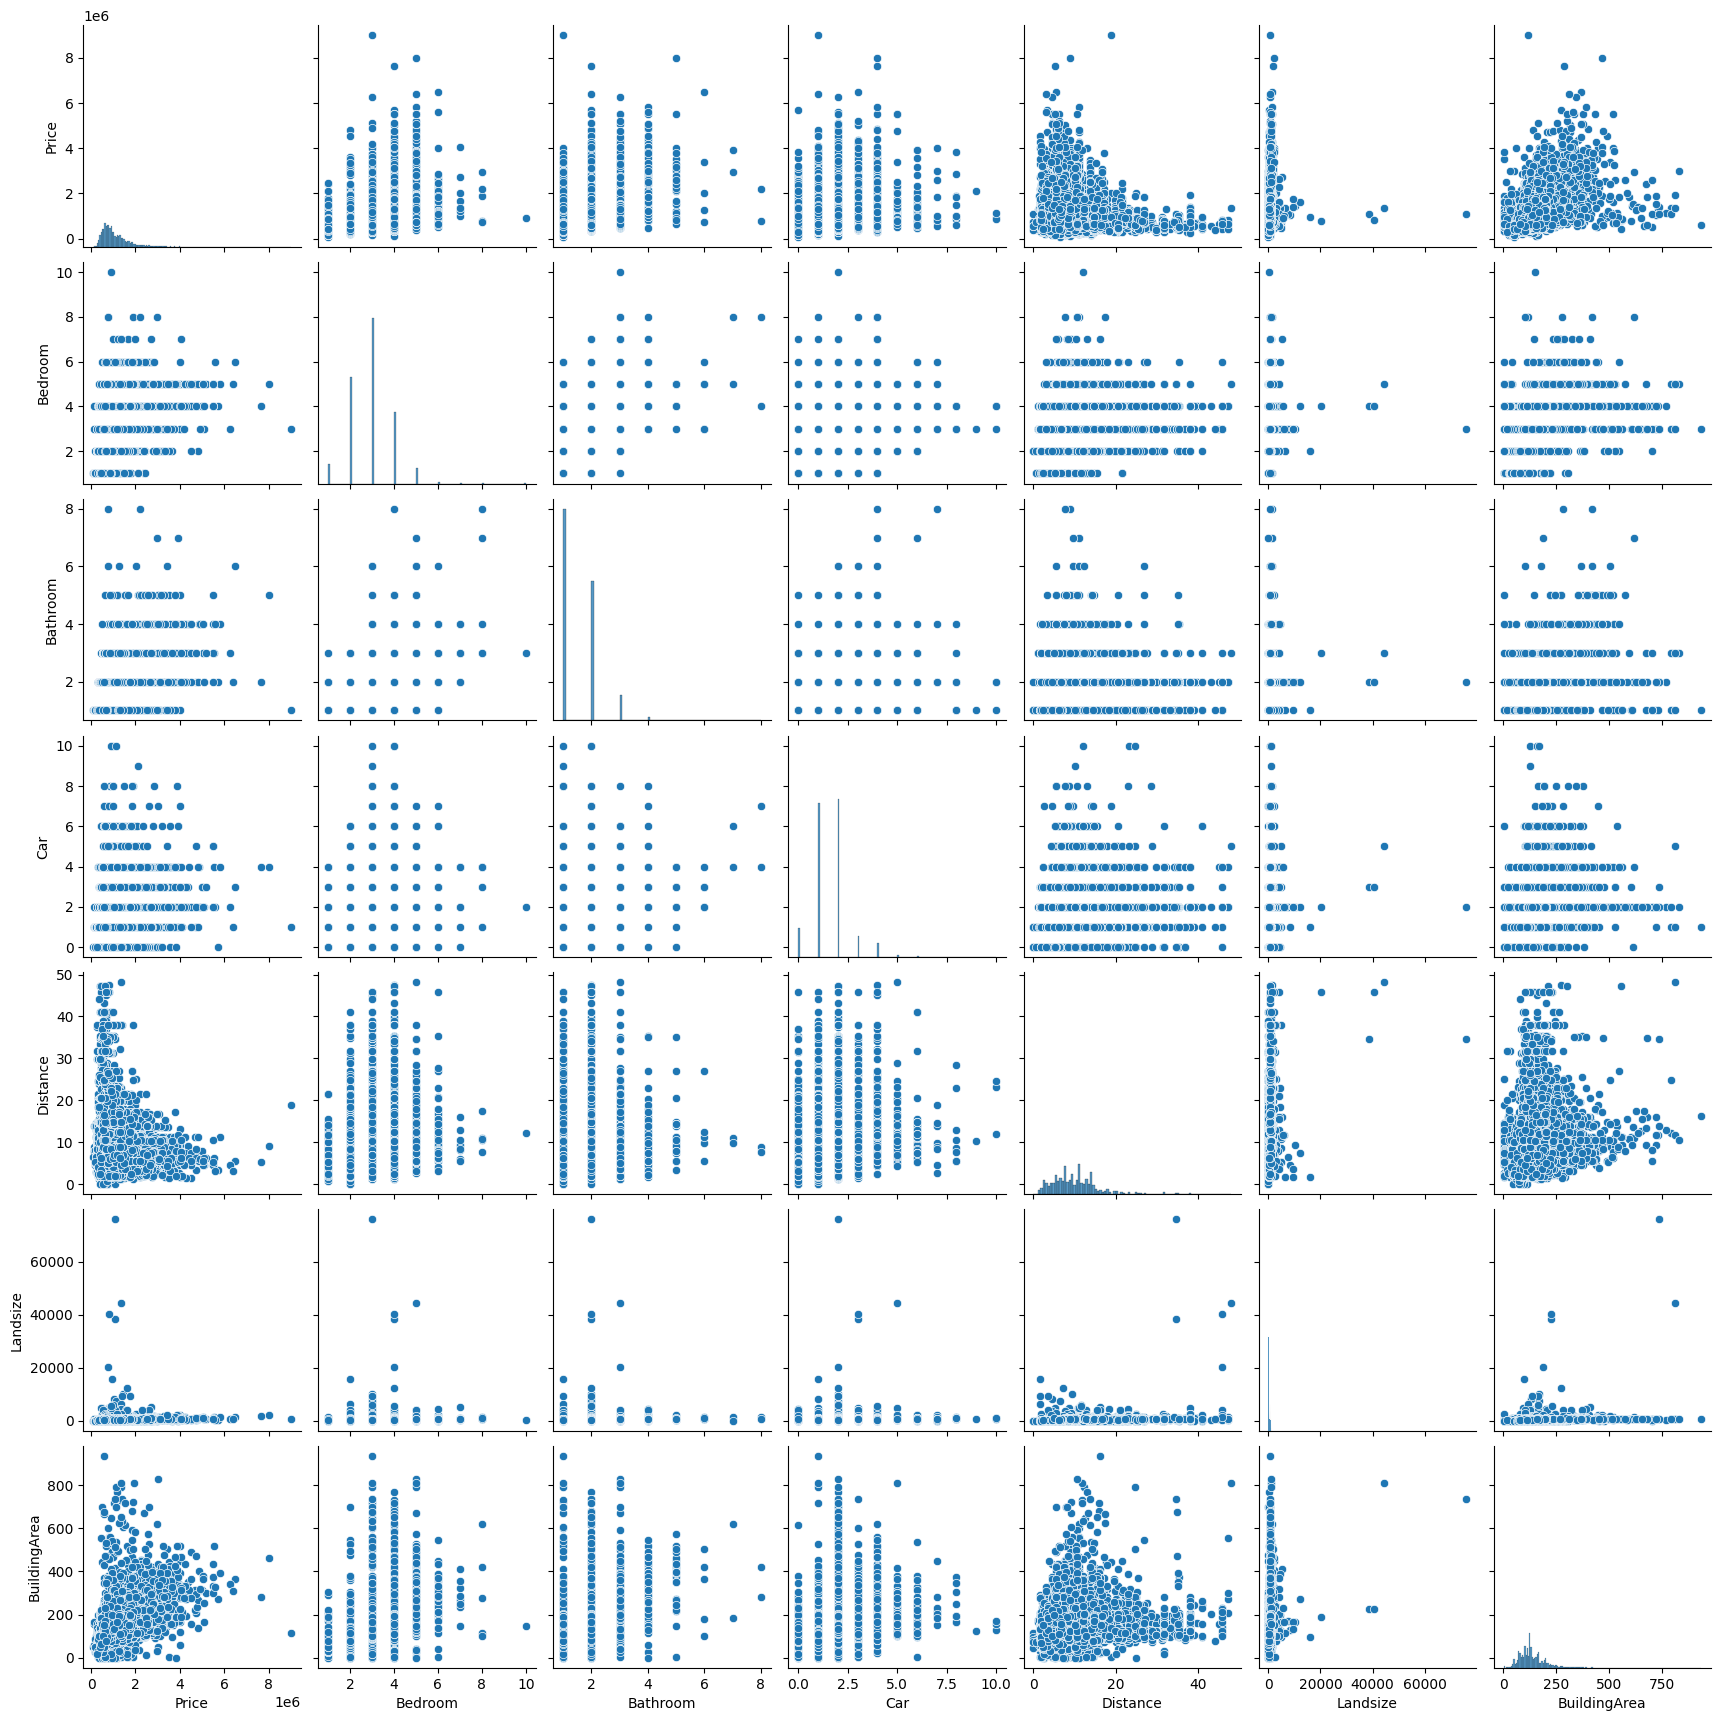

In [27]:
# Explore the relationships between quantitative variables and visualize correlations.
sns.pairplot(data=melb_data[quant_columns])
plt.show()

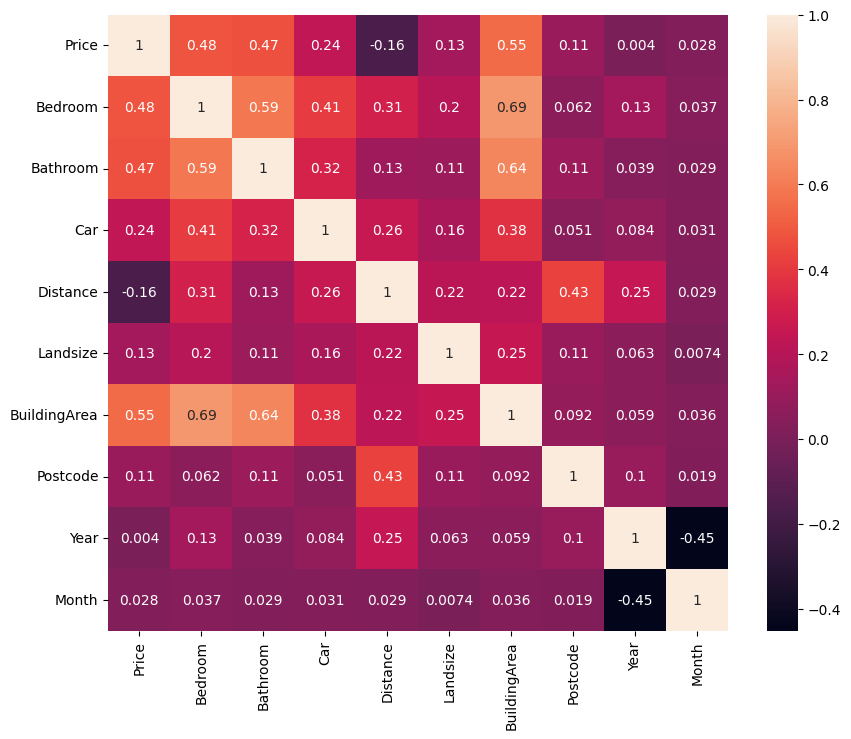

In [28]:
# Calculate the correlation matrix for the specified quantitative columns
corr_test = melb_data[quant_columns_ex].corr()

# Set the size of the figure
plt.figure(figsize=(10, 8))

# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_test, annot=True)
plt.show()

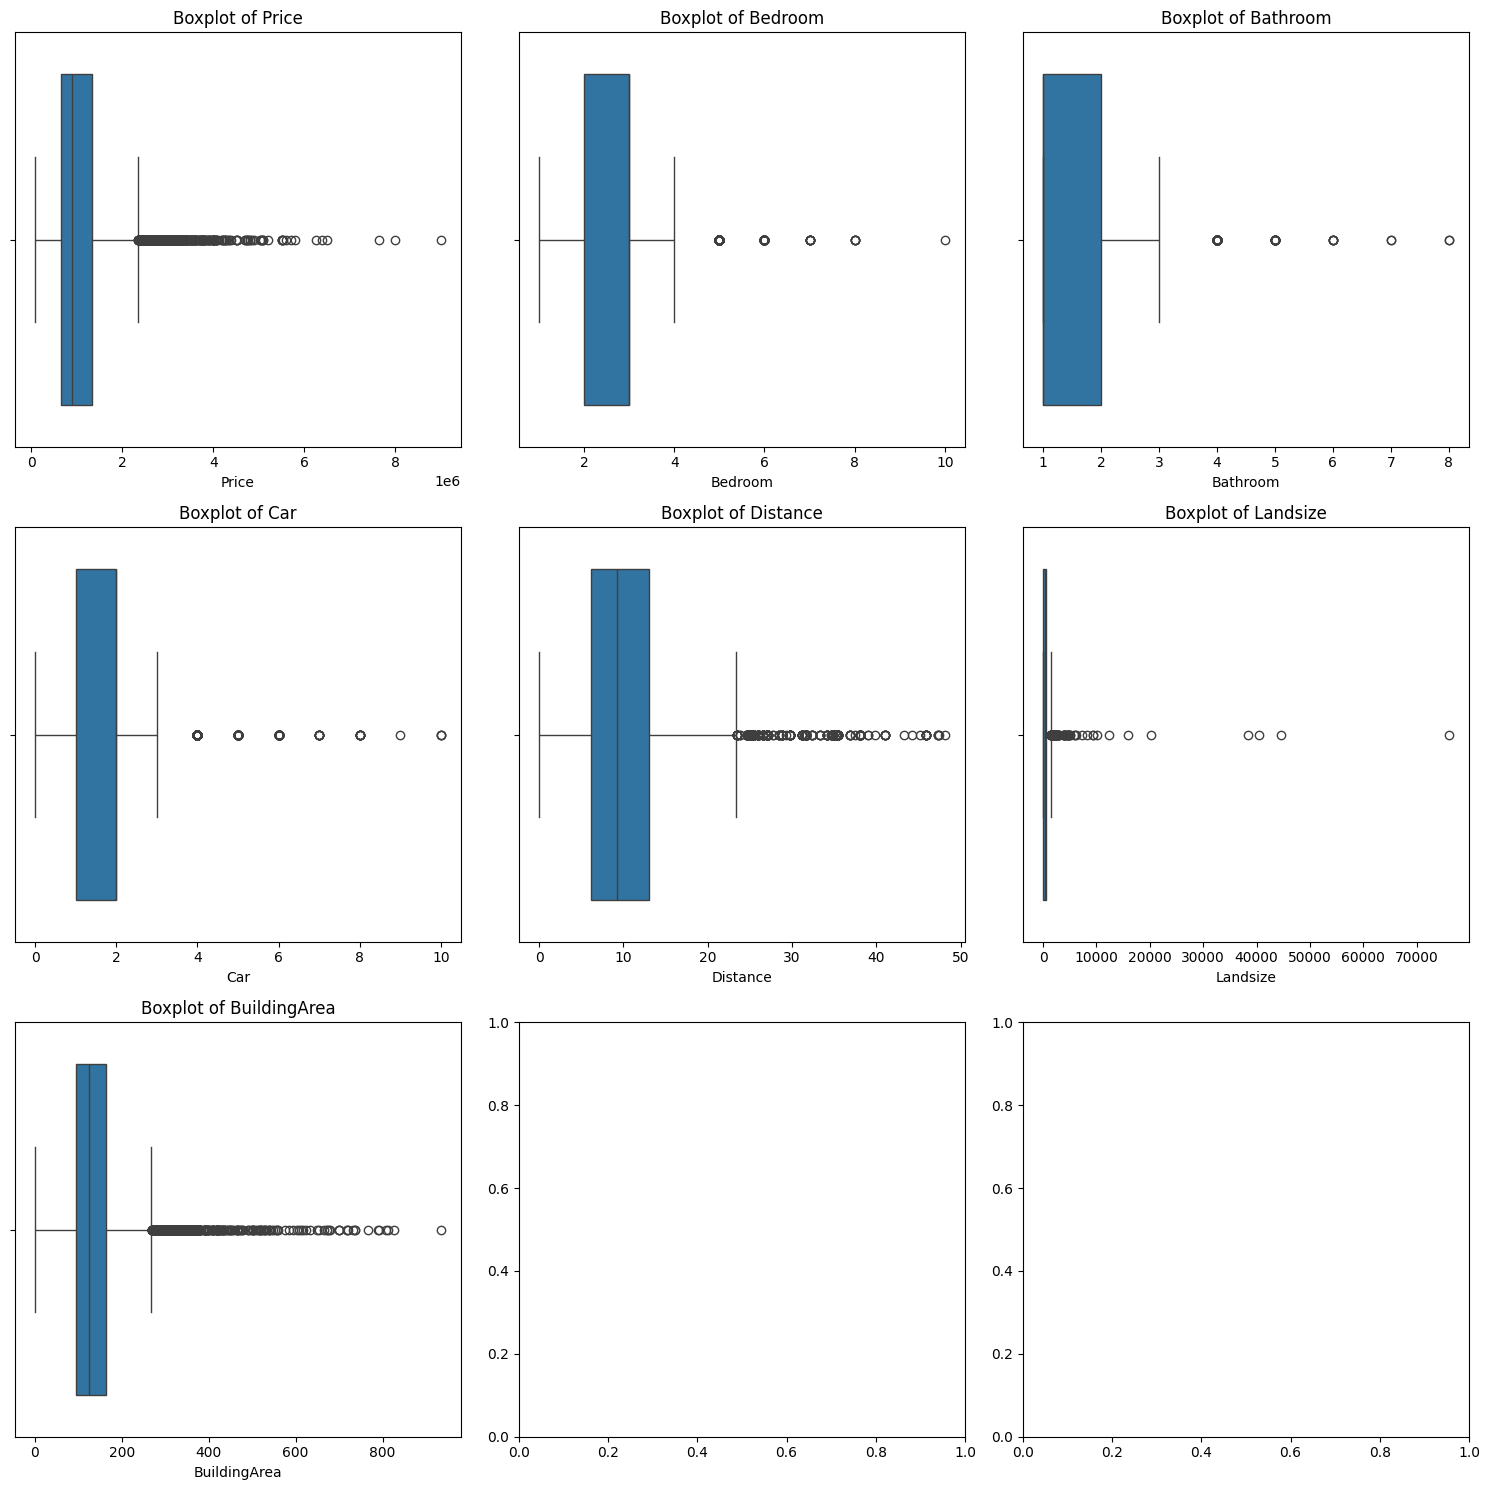

In [29]:
# Plot boxplots for selected quantitative variables to analyze distribution after 'BuildingArea' imputation.
plot_utils.plot_box(data=melb_data, column_list=quant_columns, rows=3, cols=3)

## **Export Data**

In [30]:
# Construct the full file path
output_file_path = os.path.join(script_dir, '01_Data_Cleaning', '1_cleaned_melb_data.csv')

# Export the cleaned and processed data to a new CSV file
melb_data.to_csv(output_file_path, index=False)  # Export without the index